## 載入套件及資料集

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# FNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# CNN
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam

# data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

## 資料前處理 (Data Preprocessing)

讀取 CIFAR 10 資料集

In [2]:
name_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
(X_train, y_train0), (X_test, y_test0) = datasets.cifar10.load_data()

#標準化 
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

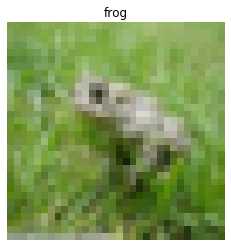

In [4]:
idx = np.random.randint(X_train.shape[0])
X_sample = X_train[idx]
y_sample = y_train0[idx].squeeze()

plt.imshow(X_sample)
plt.title(name_list[y_sample])
plt.axis('off');


## 建立卷積神經網路

修改部分：將卷積層的filter數量改為9, 81, 243，並將全連接層的神經元數量下修至128。

In [5]:
CNN_layers = [Conv2D(9, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu', name='Conv_1'),
              MaxPool2D(),
              Conv2D(81, (3, 3), padding='same', activation='relu', name='Conv_2'),
              MaxPool2D(),
              Conv2D(243, (3, 3), padding='same', activation='relu', name='Conv_3'),
              GlobalAveragePooling2D()]

FC_layers = [Dense(units=128, activation='relu'),
             Dense(units=10, activation='softmax')]

In [6]:
model = Sequential(CNN_layers+FC_layers)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 32, 32, 9)         252       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 9)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 16, 16, 81)        6642      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 81)          0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 8, 8, 243)         177390    
_________________________________________________________________
global_average_pooling2d (Gl (None, 243)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

### 編譯模型: 設定模型訓練時的設定

- Optimizer: Stochastic Gradient Descent (SGD)
- Loss: categorical cross-entropy 

In [7]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(),
              metrics=['categorical_accuracy'])

### 訓練模型: 透過訓練來學習分類資料的函數

修改部分: 將batch size改為80 epochs改成4次

In [8]:
model.fit(X_train, y_train, 
          batch_size=80, 
          epochs=4,
          validation_data=(X_test, y_test)
          )

Train on 50000 samples, validate on 10000 samples
Epoch 1/4
50000/50000 [==============================] - 293s 6ms/sample - loss: 1.7962 - categorical_accuracy: 0.3166 - val_loss: 1.5583 - val_categorical_accuracy: 0.4165
Epoch 2/4
50000/50000 [==============================] - 300s 6ms/sample - loss: 1.5002 - categorical_accuracy: 0.4450 - val_loss: 1.5846 - val_categorical_accuracy: 0.4338
Epoch 3/4
50000/50000 [==============================] - 288s 6ms/sample - loss: 1.3794 - categorical_accuracy: 0.4926 - val_loss: 1.3043 - val_categorical_accuracy: 0.5287
Epoch 4/4
50000/50000 [==============================] - 280s 6ms/sample - loss: 1.2874 - categorical_accuracy: 0.5352 - val_loss: 1.2335 - val_categorical_accuracy: 0.5587


### 模型預測準確率

In [10]:
score_train = model.evaluate(X_train, y_train)
score_test = model.evaluate(X_test, y_test)

print(f'Train Accuracy: {score_train[1]*100}')
print(f'Test Accuracy: {score_test[1]*100}')

10000/10000 [==============================] - 21s 2ms/sample - loss: 1.2335 - categorical_accuracy: 0.5587
Train Accuracy: 55.9719979763031
Test Accuracy: 55.87000250816345


## 遷移學習

In [11]:
# 導入cifar100的資料
(U_train, v_train0), (U_test, v_test0) = datasets.cifar100.load_data()

# 標準化
U_train = U_train / U_train.max()
U_test = U_test / U_test.max()

# One-hot encoding
v_train = to_categorical(v_train0, 100)
v_test = to_categorical(v_test0, 100)

169009152/169001437 [==============================] - 81s 0us/step


### 用frozen的方式訓練
新增cifar100的全連接層，神經元分別為128,64,100

In [12]:
for layer in CNN_layers:
    layer.trainable = False

In [13]:
FC_layers_CF100 = [Dense(units=128, activation='relu'),
                   Dense(units=64, activation='relu'),
                   Dense(units=100, activation='softmax')]

In [14]:
model_CF100 = Sequential(CNN_layers+FC_layers_CF100)
model_CF100.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 32, 32, 9)         252       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 9)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 16, 16, 81)        6642      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 81)          0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 8, 8, 243)         177390    
_________________________________________________________________
global_average_pooling2d (Gl (None, 243)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

### 遷移學習的訓練方式
* Fine-tune: 新資料集的樣本數夠多，整個模型重新訓練
* Frozen: 當新資料集的樣本數不夠多，凍結借來的部分，只針對新建立的神經網路層訓練

In [15]:
model_CF100.compile(loss='categorical_crossentropy', 
                    optimizer=Adam(),
                    metrics=['categorical_accuracy'])

model_CF100.fit(U_train, v_train,
                batch_size=80, 
                epochs=4,
                validation_data=(U_test, v_test)
                )

Train on 50000 samples, validate on 10000 samples
Epoch 1/4
50000/50000 [==============================] - 170s 3ms/sample - loss: 3.9132 - categorical_accuracy: 0.0985 - val_loss: 3.6273 - val_categorical_accuracy: 0.1395
Epoch 2/4
50000/50000 [==============================] - 162s 3ms/sample - loss: 3.5161 - categorical_accuracy: 0.1594 - val_loss: 3.4249 - val_categorical_accuracy: 0.1778
Epoch 3/4
50000/50000 [==============================] - 163s 3ms/sample - loss: 3.3605 - categorical_accuracy: 0.1860 - val_loss: 3.3207 - val_categorical_accuracy: 0.1989
Epoch 4/4
50000/50000 [==============================] - 166s 3ms/sample - loss: 3.2619 - categorical_accuracy: 0.2048 - val_loss: 3.2306 - val_categorical_accuracy: 0.2129


### 查看準確率

In [17]:
score_train = model_CF100.evaluate(U_train, v_train)
score_test = model_CF100.evaluate(U_test, v_test)

print(f'Train Accuracy: {score_train[1]*100}')
print(f'Test Accuracy: {score_test[1]*100}')

10000/10000 [==============================] - 32s 3ms/sample - loss: 3.2306 - categorical_accuracy: 0.2129
Train Accuracy: 21.663999557495117
Test Accuracy: 21.289999783039093


### 查看舊模型準確率是否受影響
舊模型表現不變，因為訓練方式使用frozen，沒有再將借來的網路重新訓練

In [20]:
score_train = model.evaluate(X_train, y_train)
score_test = model.evaluate(X_test, y_test)
print(f'Train Accuracy: {score_train[1]*100}')
print(f'Test Accuracy: {score_test[1]*100}')

10000/10000 [==============================] - 24s 2ms/sample - loss: 1.2335 - categorical_accuracy: 0.5587
Train Accuracy: 55.9719979763031
Test Accuracy: 55.87000250816345
